In [2]:
# Including Required packages
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import datetime
import timezonefinder, pytz
from pytz import timezone
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import desc
from graphframes import *

In [3]:
from pandas import Series
from scipy.stats import multivariate_normal
multivariate_gaussian_pdf = multivariate_normal.pdf

In [4]:
test = pd.read_csv('C:\\Term2\\Practicum\\cabdata_form.csv')

In [16]:
## Convert unix Timestamp to British Standard time as Lat/Long corresponds to Portugal area
unix_timestamp = test['TIMESTAMP'].values
local_time=[]
for i in range(len(unix_timestamp)):
    local_time.append(pd.to_datetime(datetime.datetime.fromtimestamp(test['TIMESTAMP'][i]).astimezone(timezone('Europe/London')).strftime("%Y-%m-%d %H:%M:%S")))
test['local_time']=local_time
test = test.set_index(['local_time'])

In [13]:
## Start Latitudes/Longitudes
start_lat=[]
start_lon=[]
lats=test['POLYLINE'].values
for i in range(len(lats)):
    if lats[i]=='[]':
        start_lat.append(0)
        start_lon.append(0)
    else:
        start_lat.append(float(lats[i].split(']')[0].replace('[','').split(',')[0]))
        start_lon.append(float(lats[i].split(']')[0].replace('[','').split(',')[1]))

In [86]:
## End Latitudes/Longitudes
y=[]
longitude=[]
latitude=[]
for i in range(len(x)):
    a= x[i].replace('[','').split('],')
    y1= [s.replace("]", '') for s in a]
    y.append(y1)
for j in range(len(y)):
    try:
        a=[float(s.split(',')[0]) for s in y[j]]
        longitude.append(a)
        b=[float(s.split(',')[1]) for s in y[j]]
        latitude.append(b)
    except:
        a=[s.split(',')[0] for s in y[j]]
        longitude.append(a)
        b=[s.split(',')[0] for s in y[j]]
        latitude.append(b)

end_lat=[]
end_lon=[]
for i in range(len(latitude)):
    if len(latitude[i])<=1:
        end_lat.append(0)
        end_lon.append(0)
    else:
        end_lat.append(latitude[i][-1])
        end_lon.append(longitude[i][-1])


KeyboardInterrupt



In [43]:
## Function to calculate distance between 2 lat/lon coordinates
from math import radians, cos, sin, asin, sqrt
def get_dist(lon1, lat1, lon2, lat2):
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    distance = 6371* c
    return round(distance*1000,2)

In [28]:
## Find total distance of ride
tot_dist=[]
for i in range(len(start_lat)):
    if (start_lat[i]==0) or (end_lat[i]==0):
        tot_dist.append(0)
    else:
        tot_dist.append(get_dist(start_lon[i],start_lat[i],end_lon[i],end_lat[i]))
test['Tot_Dist']=tot_dist
test['Start_Latitude']=start_lat
test['Start_Longitude']=start_lon
test['End_Latitude']=end_lat
test['End_Longitude']=end_lon

In [70]:
##Find total time of ride
time=[]
for i in range(len(latitude)):
    if len(latitude[i])>1:
        time.append((len(latitude[i])-1)*15/60)
    else:
        time.append(0)
test['Time']=time

In [51]:
## Find actual value of Day type
## Check if the date is weekday or weekend, Mon-Thrus assigned as A i.e. Weekday, Friday Assigned as Before Holiday(BH)
x=test.index
weekday=[0,1,2,3]
day_type=[]
for i in range(len(x)):
    a=x[i].weekday()
    if a in weekday:
        day_type.append("A")
    elif a == 4:
        day_type.append("BH")
    elif a==5:
        day_type.append("Sat")
    else:
        day_type.append("Sun")
test['Day_Type']=day_type
## Check if the day is public holiday?
from datetime import date
import holidays
PT_holidays = holidays.CountryHoliday('PTE') ## PTE for Portugal
x=test['TIMESTAMP'].values
p_hol=[]
for i in range(len(x)):
    a1=int(x[i]) in PT_holidays
    if a1:
        p_hol.append("Hol")
    else:
        p_hol.append("A")
test['Pub_Hol']=p_hol


x=test[test['Pub_Hol']=="Hol"].index.date
y=np.unique(x)
## Creating an array of dates which are just before Public Holidays, based on value of y
day_bf=[datetime.date(2013, 8, 14),datetime.date(2013, 12, 7),datetime.date(2013, 12, 23),datetime.date(2013, 12, 29),
 datetime.date(2014, 3, 3), datetime.date(2014, 4, 17),datetime.date(2014, 4, 24),datetime.date(2014, 4, 30),
 datetime.date(2014, 6, 9),datetime.date(2014, 6, 12)]
x1=test.index.date
bf=[]
for i in range(len(x1)):
    if x1[i] in day_bf:
        bf.append("B")
    else:
        bf.append("A")
test['Bef_Hol']=bf
test['combined']=test['Day_Type']+test['Pub_Hol']+test['Bef_Hol']
All_type=test['combined'].values
type_b = ['SatAA','SunAA','AHolA','BHHolA','SunHolA','SatAB','SunAB','SatHolA']
type_c = ['BHAA','AAB']
Fin_day_type=[]
for i in range(len(All_type)):
    if All_type[i] in type_c:
        Fin_day_type.append("C")
    elif All_type[i] in type_b:
        Fin_day_type.append("B")
    else:
        Fin_day_type.append("A")
test["Fin_Day_Type"]=Fin_day_type

In [9]:
## Check the number of trips getting originated by calling, based on customer ID
## Generally a direct customer might take taxi 3-4 times in a day, but there are cases where number of trips per day
## from same customer ID >200, for which we can infer that these customers corresponds to B2B Business
aa1=pd.DataFrame(test[test['CALL_TYPE']=='A']['ORIGIN_CALL'].value_counts())
aa1[aa1['ORIGIN_CALL']>1350]/365


,ORIGIN_CALL
2002.0,157.728767
63882.0,17.550685
2001.0,6.846575


In [608]:
# Number of Taxi Plying
dd=test.groupby([test.index.date,'TAXI_ID']).agg({'TRIP_ID':[np.size]})
dd.to_csv('C:\\Term2\\Practicum\\cabdata_taxigroup.csv')

In [631]:
## Missing Value Analysis
##1) If trip is originated by calling, do we have all 'Origin_call' Captured?
##2) If trip is originated in stand, do we have all 'Origin_stand' Captured?
##3) If trip is originated in stand and stand id not captured, then strating lat/long point available?
##4) All Taxi_ID, Timestamp, Trip ID fields captured?
##5) How many cases are there with route 'MISSING_DATA' as true
test[(test['CALL_TYPE']=='A')&(test['ORIGIN_CALL'].isnull())]
test[(test['CALL_TYPE']=='B')&(test['ORIGIN_STAND'].isnull())].shape
test[(test['CALL_TYPE']=='B')&(test['ORIGIN_STAND'].isnull())&(test['Start_Latitude']==0)].shape
test[test['TRIP_ID'].isnull()]
test[test['CALL_TYPE'].isnull()]
test[test['TAXI_ID'].isnull()]
test[test['TIMESTAMP'].isnull()]
test[test['MISSING_DATA']==True].shape

(10, 20)

(-9.5, -7)

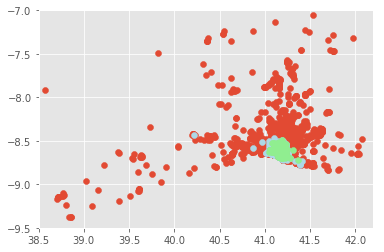

In [215]:
## Basic Plot - Spread of trips based on call, Stand or Waving Hand origination
plt.scatter(test[test['CALL_TYPE'] == 'C']['Start_Latitude'],test[test['CALL_TYPE'] == 'C']['Start_Longitude'])
plt.scatter(test[test['CALL_TYPE'] == 'A']['Start_Latitude'],test[test['CALL_TYPE'] == 'A']['Start_Longitude'],c='lightblue')
plt.scatter(test[test['CALL_TYPE'] == 'B']['Start_Latitude'],test[test['CALL_TYPE'] == 'B']['Start_Longitude'], c='lightgreen')
plt.xlim(38.5, 42.2)
plt.ylim(-9.5, -7)

In [63]:
## Group on the basis of Day type, then group by hour of day and then group by call type.
## Write to CSV and do hour by Analysis for each day type based on call type
df_group_day_call_type= test.groupby(['Fin_Day_Type',test.index.hour,'CALL_TYPE']).agg({'TRIP_ID':[np.size]})
df_group_day_call_type.to_csv('C:\\Term2\\Practicum\\df_group_day_call_type.csv')
## Get the total number of days based on day type i.e how many total Working days, Before Holiday days and Holiday days
l1=len(np.unique(test[test['Fin_Day_Type']=='A'].index.date))
l2=len(np.unique(test[test['Fin_Day_Type']=='B'].index.date))
l3=len(np.unique(test[test['Fin_Day_Type']=='C'].index.date))

In [704]:
## Interim saving of data to retreive in case of failure
test.to_csv('C:\\Term2\\Practicum\\cabdata_form.csv')
test1 = test[['CALL_TYPE','ORIGIN_STAND','Start_Latitude','Start_Longitude','End_Latitude','End_Longitude','Fin_Day_Type','Time','Tot_Dist']].copy()
test1.to_csv('C:\\Term2\\Practicum\\cabdata_form1.csv')

#x1.to_csv('C:\\Term2\\Practicum\\x1.csv')

Create cluster for end points for trips which originated from Taxi stand.
Identify the clusters having max end points.
Then create graphframe so that we can check the nearest stand IDs for a given stand ID, so that we can channelize the taxi's if required

In [220]:
# Create subset data where trip orginated at stand between 10 to 11 AM on a working day
test_wd_B=test.loc[(test['Fin_Day_Type']=="A")&(test['CALL_TYPE']=="B")&(test.index.hour>=10)&(test.index.hour<=11)]
x2=test_wd_B.groupby(test_wd_B['ORIGIN_STAND']).agg({'TRIP_ID':[np.size],'Start_Latitude':[np.mean],'Start_Longitude':[np.mean]})
#x2.to_csv('C:\\Term2\\Practicum\\stand_mean.csv')

In [13]:
## Cluster end lat/longs
clus_stand=test_wd_B[['End_Latitude','End_Longitude']].copy()
KM1 = KMeans(n_clusters = 10, max_iter = 300) 
KM1.fit(clus_stand) 
test_wd_B['Cluster_num']=KM1.labels_ 

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [20]:
## Busiest taxi stand during above time
test_wd_B['ORIGIN_STAND'].value_counts()

15.0    6953
57.0    3994
18.0    3652
9.0     3315
33.0    2455
        ... 
43.0      52
46.0      45
8.0       32
4.0       19
5.0        2
Name: ORIGIN_STAND, Length: 62, dtype: int64

In [14]:
# Cluster ending with max number of rides
test_wd_B['Cluster_num'].value_counts()

2    29272
4    13210
3    12243
5     2744
0     2100
8     1224
1      604
9       37
6       12
7        3
Name: Cluster_num, dtype: int64

In [15]:
## Add end cluster centroid
test_wd_B['Clus_Mean_Lat']=0
test_wd_B['Clus_Mean_Lon']=0
cent=KM1.cluster_centers_
for i in range(10):
    test_wd_B['Clus_Mean_Lat'][test_wd_B['Cluster_num']==i]=cent[i][0]
    test_wd_B['Clus_Mean_Lon'][test_wd_B['Cluster_num']==i]=cent[i][1]

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying 

In [1]:
## Create Graphframe for finding nearest taxi stand for a given taxi stand
sqlContext = SQLContext(sc)
df = sqlContext.read.load("C:\\Term2\\Practicum\\Create_Graph_Stand.csv",format='com.databricks.spark.csv',header='true',inferSchema='true')

In [6]:
# Creating view 
df.createOrReplaceTempView("stand")

In [13]:
dist_val = sqlContext.sql("SELECT * FROM stand")

In [10]:
dist_val.show(10)

+----------+-----------+------------+
|Station_ID|        Lat|        Long|
+----------+-----------+------------+
|         1|41.17725642|-8.621450848|
|         2|41.15619782|-8.607173383|
|         3|41.17066149|-8.637648806|
|         4|  41.143676|  -8.6348005|
|         5| 41.1836265|    -8.66007|
|         6|41.18404131| -8.59773778|
|         7|  41.159751|-8.630141216|
|         8|41.15162468|-8.580584032|
|         9|41.14464654| -8.62151382|
|        10|41.15027338|-8.615613631|
+----------+-----------+------------+
only showing top 10 rows



In [12]:
#Creating list for all values

lat_list = list(
    dist_val.select('Lat').toPandas()['Lat']
)
long_list = list(
    dist_val.select('Long').toPandas()['Long']
)
st_id_list = list(
    dist_val.select('Station_ID').toPandas()['Station_ID']
)


In [14]:
# creating values for edges 
src=[]
dest=[]
dis=[]
i=0
while i<(len(st_id_list)-1):
    j=i+1
    while j<=(len(st_id_list)-1):
        dist = get_dist(lat_list[i],long_list[i],lat_list[j],long_list[j])
        src.append(st_id_list[i])
        dest.append(st_id_list[j])
        dis.append(dist)
        
            
        j=j+1
    i=i+1

In [17]:
#Creating edges dataframe
from pyspark.sql.types import *
Schema = StructType([StructField("src", StringType())\
                      ,StructField("dst", StringType())\
                      ,StructField("Distance", FloatType())])

edge_list = zip(src, dest,dis)

df_edges = sqlContext.createDataFrame(edge_list,Schema) 

In [18]:
# Creating vertices Dataframe
Schema2 = StructType([StructField("id", StringType())\
                      ,StructField("Lat", FloatType())\
                      ,StructField("Lon", FloatType())])

vert_list = zip(st_id_list, lat_list,long_list)

df_vertices = sqlContext.createDataFrame(vert_list,Schema2) 

In [19]:
df_edges.show(10)

+---+---+---------+
|src|dst| Distance|
+---+---+---------+
|  1|  2|2807.2295|
|  1|  3|1941.5786|
|  1|  4|3978.9746|
|  1|  5| 4350.978|
|  1|  6| 2740.256|
|  1|  7| 2153.479|
|  1|  8| 5347.064|
|  1|  9|3585.0864|
|  1| 10|3036.6748|
|  1| 11|1170.8577|
+---+---+---------+
only showing top 10 rows



In [20]:
df_vertices.show(10)

+---+---------+---------+
| id|      Lat|      Lon|
+---+---------+---------+
|  1|41.177258| -8.62145|
|  2|41.156197|-8.607173|
|  3|41.170662|-8.637649|
|  4|41.143677|-8.634801|
|  5|41.183628| -8.66007|
|  6| 41.18404|-8.597737|
|  7| 41.15975|-8.630141|
|  8|41.151627|-8.580584|
|  9|41.144646|-8.621513|
| 10|41.150272|-8.615614|
+---+---------+---------+
only showing top 10 rows



In [21]:
g = GraphFrame(df_vertices, df_edges)

In [29]:
paths = g.find("(a)-[e]->(b)").filter("e.Distance < 500").filter("a.id=15")

In [35]:
e2 = paths.select("e.src", "e.dst", "e.Distance")
display = e2.toPandas()
display.sort_values('Distance')

,src,dst,Distance
1,15,27,153.358124
4,15,44,166.995300
2,15,60,300.865967
3,15,23,336.484955
0,15,18,448.480255


Finding the best location where taxis can be placed between 4-6 AM on Holidays.

In [21]:
#Subset Data
test_Hol_C=test.loc[(test['Fin_Day_Type']=="C")&(test['CALL_TYPE']=="C")&(test.index.hour>=4)&(test.index.hour<=6)]

In [24]:
##Cluster
clus_taxi=test_Hol_C[['Start_Latitude','Start_Longitude']].copy()
KM2 = KMeans(n_clusters = 10, max_iter = 300) 
KM2.fit(clus_taxi) 
test_Hol_C['Cluster_num']=KM2.labels_ 

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [27]:
test_Hol_C['Clus_Mean_Lat']=0
test_Hol_C['Clus_Mean_Lon']=0
cent2=KM2.cluster_centers_
for i in range(10):
    test_Hol_C['Clus_Mean_Lat'][test_Hol_C['Cluster_num']==i]=cent2[i][0]
    test_Hol_C['Clus_Mean_Lon'][test_Hol_C['Cluster_num']==i]=cent2[i][1]

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying 

In [29]:
test_Hol_C.to_csv('C:\\Term2\\Practicum\\hol_start.csv')

In [30]:
## Which cluster having max rides
test_Hol_C['Cluster_num'].value_counts()

2    41770
8    10704
0     5469
9     3441
3     3033
4     2459
5      382
1      199
7       28
6        2
Name: Cluster_num, dtype: int64

Clustering the locations where people are calling for taxi and finding optimum number pf taxis and location for each cluster

In [31]:
call_taxi=test.loc[(test['CALL_TYPE']=='A')&(test['Fin_Day_Type']=='A')]

In [32]:
## Cluster
X2=call_taxi[['Start_Latitude','Start_Longitude']].copy()
KM3 = KMeans(n_clusters = 13, max_iter = 300) 
KM3.fit(X2) 
call_taxi['Cluster_num']=KM3.labels_ 
cent3=KM3.cluster_centers_

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [33]:
call_taxi['Clus_Mean_Lat']=0
call_taxi['Clus_Mean_Lon']=0
for i in range(13):
    call_taxi['Clus_Mean_Lat'][call_taxi['Cluster_num']==i]=cent3[i][0]
    call_taxi['Clus_Mean_Lon'][call_taxi['Cluster_num']==i]=cent3[i][1]

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying 

In [34]:
call_taxi.to_csv('C:\\Term2\\Practicum\\call_taxi.csv')

In [39]:
#Predict cluster of a new point
KM3.predict([[41.160087,-8.680554]])

array([4])

In [41]:
#find the cluster mean
cent3[4][1]

-8.678629448814613

In [44]:
#Cluster 12 and 2 are cliques for cluster 4, find min distance
x1=get_dist(-8.680554,41.160087,cent3[4][1],cent3[4][0])+get_dist(-8.680554,41.160087,cent3[12][1],cent3[12][0])
x2=get_dist(-8.680554,41.160087,cent3[4][1],cent3[4][0])+get_dist(-8.680554,41.160087,cent3[2][1],cent3[2][0])

In [45]:
#find the min
x1-x2

-1249.6899999999998

Breakdown and no-ride Analysis

In [48]:
## Find the cases where trip do not commence
no_start=test.loc[((test['Start_Latitude']==0) | (test['End_Latitude']==0))&(test['MISSING_DATA']==False)]

In [66]:
no_start[no_start['Fin_Day_Type']=='C'].shape[0]/l3

94.29565217391304

In [49]:
no_start1_1= no_start1.loc[no_start['Start_Latitude']!=0]

In [57]:
xx=pd.DataFrame(test[(test['Start_Latitude']==0)&(test['CALL_TYPE']=='B')&(test['MISSING_DATA']==False)]['ORIGIN_STAND'].value_counts())
xx[xx['ORIGIN_STAND']>100]

,ORIGIN_STAND
62.0,264
53.0,213
57.0,142
10.0,120


In [511]:
no_start1_2= no_start1.loc[(no_start1['Start_Latitude']!=0)&(no_start1['CALL_TYPE']=='C')]

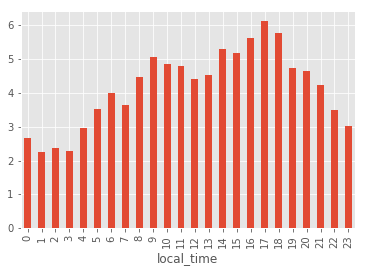

In [71]:
def f(x):
    return Series(dict(Number_Trips = x['TRIP_ID'].count()/365)) 

Day_count_A = no_start.groupby(no_start.index.hour).apply(f)
Day_count_A['Number_Trips'].plot(kind='bar')

In [74]:
no_start1=no_start.loc[(no_start.index.hour>=14)&(no_start.index.hour<=18)&(no_start['Start_Latitude']!=0)]

In [76]:
X3=no_start1[['Start_Latitude','Start_Longitude']].copy()
KM4 = KMeans(n_clusters = 10, max_iter = 300) 
KM4.fit(X3) 
no_start1['Cluster_num']=KM4.labels_ 
cent4=KM4.cluster_centers_

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [78]:
no_start1['Clus_Mean_Lat']=0
no_start1['Clus_Mean_Lon']=0
for i in range(10):
    no_start1['Clus_Mean_Lat'][no_start1['Cluster_num']==i]=cent4[i][0]
    no_start1['Clus_Mean_Lon'][no_start1['Cluster_num']==i]=cent4[i][1]

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying 

In [79]:
no_start1.to_csv('C:\\Term2\\Practicum\\no_start.csv')

Congested Routes - During Working Day between 10-11 AM, if the distance between 2 points is between 40 and 100 metre then conjestion is Amber, if below than 40 then Red else Green

In [81]:
test_path=test.loc[(test['End_Latitude']>0)&(test['Start_Latitude']>0)&(test.index.hour==10)&(test['Fin_Day_Type']=='A')]   
x_hm=test_path['POLYLINE'].values

In [82]:
## Exract all lat lon pairs from each route
y_hm=[]
longitude_hm=[]
latitude_hm=[]
for i in range(len(x_hm)):
    a= x_hm[i].replace('[','').split('],')
    y1= [s.replace("]", '') for s in a]
    y_hm.append(y1)
for j in range(len(y_hm)):
    try:
        a=[float(s.split(',')[0]) for s in y_hm[j]]
        longitude_hm.append(a)
        b=[float(s.split(',')[1]) for s in y_hm[j]]
        latitude_hm.append(b)
    except:
        a=[s.split(',')[0] for s in y_hm[j]]
        longitude_hm.append(a)
        b=[s.split(',')[0] for s in y_hm[j]]
        latitude_hm.append(b)

In [103]:
# Find distance between each lat/lon pairs and find congested lat/lon based on distance tarvelled. If in a route 
## more than 50% points are congested maked as congested route
ind_lat=[]
ind_lon=[]
cong=[]
dist=[]
route=[]
fin_con=[]
for i in range(len(longitude_hm)):
    x1=len(longitude_hm[i])
    c=0
    if (x1<=240)&(x1>=20):
        for j in range(len(longitude_hm[i])):
            ind_lat.append(latitude_hm[i][j])
            ind_lon.append(longitude_hm[i][j])
            if j==0:
                cong.append('S')
                dist.append(0)
            else:
                x=get_dist(longitude_hm[i][j],latitude_hm[i][j],longitude_hm[i][j-1],latitude_hm[i][j-1])
                dist.append(x)
                if (x>=40.0)&(x<=100):
                    cong.append('A')
                elif x<40.0:
                    c+=1
                    cong.append('R')
                else:
                    cong.append('G')
            route.append(i)
        if (c/(x1-1)>0.5):
            fin_con.append(i)
            

In [106]:
route_db=pd.DataFrame(list(zip(ind_lat,ind_lon,cong,dist,route)),columns=['Latitude','Long','Congestion','Dist','route'])

In [109]:
d1=route_db.loc[route_db['route'].isin(fin_con)]

In [113]:
d2=d1.loc[d1['Congestion']=='R']

In [110]:
d1.to_csv('C:\\Term2\\Practicum\\conj.csv')

In [114]:
X5=d2[['Latitude','Long']].copy()
KM5 = KMeans(n_clusters = 10, max_iter = 300) 
KM5.fit(X5) 
d2['Cluster_end']=KM5.labels_ 
cent5=KM5.cluster_centers_

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [133]:
d2['Cluster_end'].value_counts()

0    78605
5    54542
1    33784
6    27341
9    22251
2    21327
7    17212
3    10690
8     3620
4     2404
Name: Cluster_end, dtype: int64

In [125]:
fin=pd.DataFrame(d2[d2['Cluster_end'].isin([0,5])]['route'].value_counts())
fin_route=fin[fin['route']>100].index
most_cnj=d1.loc[d1['route'].isin(fin_route)]
most_cnj.to_csv('C:\\Term2\\Practicum\\most_conj.csv')

In [553]:
x_tem=pd.DataFrame(d1[d1['Cluster_end']==3]['route'].value_counts())
ind=x_tem[x_tem['route']>100].index
ind

Int64Index([ 4727, 21149, 19931, 24341, 11430, 27656, 25643, 47040, 44382,
            11722, 55915,  2374,  3730,  1999, 35249, 29219, 20982, 29579,
             2333,   954, 45966, 48075, 26362, 39322, 15304, 20392, 56567,
             9074, 12370, 32406, 48459, 12399, 43620, 48915, 20470, 38615,
            13910, 46848, 47884, 47017, 50573, 57287, 48438, 50663,  4829,
            29453, 30646, 19759, 42385, 16631, 33352],
           dtype='int64')

End point Prediction

In [137]:
test1 = pd.read_csv('C:\\Term2\\Practicum\\cabdata_form1.csv')

In [138]:
test2 = test1[(test1['Start_Latitude']!=0)&(test1['End_Latitude']!=0)]

In [139]:
XX= test2[['Start_Latitude','Start_Longitude']].copy()

In [140]:
XX2= test2[['End_Latitude','End_Longitude']].copy()

In [141]:
KM6 = KMeans(n_clusters = 20, max_iter = 300) 
KM6.fit(XX) 
test2['Cluster_end']=KM6.labels_ 

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [142]:
KM7 = KMeans(n_clusters = 20, max_iter = 300) 
KM7.fit(XX2) 
test2['Cluster_end2']=KM7.labels_ 

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [194]:
prdct=[[41.154885,-8.630712]]

In [195]:
cl1=KM6.predict(prdct)[0]

In [188]:
best=pd.DataFrame((test2[test2['Cluster_end']==cl1)&(test2.index.hour==10)]['Cluster_end2'].value_counts())
clus=best[best['Cluster_end2']==np.max(best['Cluster_end2'])].index
clus=clus[0]

4

In [197]:
np.mean(test2[(test2['Cluster_end']==cl1)&(test2['Cluster_end2']==clus)&(test2.index.hour==10)])

ORIGIN_STAND         25.575490
Start_Latitude       41.159780
Start_Longitude      -8.627768
End_Latitude         41.149594
End_Longitude        -8.611714
Time                 11.228871
Tot_Dist           1959.660235
Cluster_end           0.000000
Cluster_end2          4.000000
dtype: float64

In [180]:
cent7=KM7.cluster_centers_

In [181]:
cent7[clus]

array([41.14948274, -8.61048566])

Predict Next point in path

In [224]:
## Find, Cent, assign, cov and Prior to initiate GMM
def init_hmm(data,k):
    km_hmm = KMeans(n_clusters=k)
    km_hmm.fit(data)
    assign = km_hmm.labels_
    cents = km_hmm.cluster_centers_
    prior=[]
    covariance=[]
    for i in range(10):
        prior.append(data[assign==i].shape[0]/data.shape[0])
        covariance.append(np.cov(data[assign==i].T))
    return assign,cents,prior,covariance

In [225]:
def E_res_step(data,mean,prior,covariance,k):
    resp1 = np.zeros([data.shape[0], k])
    for i in range(k):
        resp1[:,i] = prior[i]*multivariate_gaussian_pdf(data, mean[i], covariance[i])
    z=resp1.sum(axis=1)
    for i in range(resp1.shape[0]):
        for j in range(resp1.shape[1]):
            resp1[i][j]=resp1[i][j]/z[i]
    return resp1

In [226]:
def M_step(data,resp,k,m_rec,cov):
    prior=resp.sum(axis=0)/data.shape[0]
    for i in range(k):
        a=resp[:,i]*(data.T)
        m_rec[i]=(a.sum(axis=1))/(resp[:,i].sum())
    for i in range(k):
        b=data-m_rec[i]
        cov[i]=(b.T).dot(b*resp[:,i][:,np.newaxis])/(resp[:,i].sum())
    return prior,m_rec,cov

In [227]:
def create_GMM(data,k):
    Likelihood=[]
    K=[]
    LLH=0
    assign,mean,prior,cov = init_hmm(data,k)
    for i in range(10):
        try:
            resp1 = E_res_step(data,mean,prior,cov,k)
            prior,mean,cov=M_step(data,resp1,k,mean,cov)
        except:
            print(i)
    assign = resp1.argmax(axis=1)
    return assig,prior,mean,cov

In [228]:
data_ch=[[41.145948,-8.612595],[41.145876,-8.612334],[41.145903,-8.611731]]

In [230]:
hmm_df=pd.DataFrame(list(test_path.index),columns=['index'])
p=[]
m=[]
covar=[]
for j in range(10):
    a1=[]
    b1=[]
    for i in range(len(latitude_hm)):
        try:
            a1.append(latitude_hm[i][j])
            b1.append(longitude_hm[i][j])
        except:
            a1.append(0)
            b1.append(0)
    c1="lat_path_"+str(j)
    c2="lon_path_"+str(j)
    c3="cluster_path"+str(j)
    hmm_df[c1]=a1
    hmm_df[c2]=b1
    x1=hmm_df.loc[:,[c1,c2]].values
    assignment,mean,prior,cov=init_hmm(x1,10)
    p.append(prior)
    m.append(mean)
    covar.append(cov)
    hmm_df[c3]=assignment

In [231]:
emmision=np.zeros([10,3])
for i in range(len(data_ch)):
    for j in range(10):
        try:
            emmision[j][i]=p[i][j]*multivariate_gaussian_pdf(data_ch[i], m[i][j], covar[i][j])
        except:
            emmision[j][i]=0
            
z=emmision.sum(axis=0)
for i in range(emmision.shape[1]):
    for j in range(emmision.shape[0]):
        emmision[j][i]=emmision[j][i]/z[i]
    

In [232]:
trans=[]
x=0
transition=np.zeros([9,10,10])
while x<9:
    c1='cluster_path'+str(x)
    c2='cluster_path'+str(x+1)
  #  print(c1,c2)
    for i in range(10):
        for j in range(10):
            try:
                transition[x][i][j]=hmm_df[(hmm_df[c1]==i)&(hmm_df[c2]==j)].shape[0]/hmm_df[hmm_df[c1]==i].shape[0]
            except:
                transition[x][i][j]=0
    x=x+1

In [233]:
delta = np.zeros([10,3])
psi = np.zeros([10,3])
delta[:,0]=p[0]*emmision[:,0]
for k in range(2):
    for i in range(10):
        delta[i,k+1]=np.max(transition[k,:,i]*delta[:,k]*emmision[i][k])
        psi[i,k+1]=np.argmax(transition[k,:,i]*delta[:,k])

In [234]:
p_star=np.max(delta[:,2])
q_star=np.argmax(delta[:,2])
q_second=int(psi[q_star,2])
q_first=psi[q_second,1]

In [249]:
print(q_first,q_second,q_star)

6.0 6 5


In [246]:

get_val_clus3=hmm_df[(hmm_df['cluster_path0']==6)&(hmm_df['cluster_path1']==6)&(hmm_df['cluster_path2']==5)]['cluster_path3'].value_counts()
x=hmm_df[(hmm_df['cluster_path0']==6)&(hmm_df['cluster_path1']==6)&(hmm_df['cluster_path2']==5)]['lat_path_3'].values
y=hmm_df[(hmm_df['cluster_path0']==6)&(hmm_df['cluster_path1']==6)&(hmm_df['cluster_path2']==5)]['lon_path_3'].values
dis=[]
for i in range(len(x)):
    dis.append(get_dist(y[i], x[i], data_ch[2][1], data_ch[2][0]))
b1=get_dist(data_ch[1][1], data_ch[1][0], data_ch[2][1], data_ch[2][0])
for i in range(len(dis)):
    
    if (dis[i]>(b1-0.1))&(dis[i]<(b1+0.1)):
        print(x[i],y[i])

41.162589 -8.60913
